In [4]:
import pandas as pd
import os
from tqdm import tqdm
from features import extract_features, feature_names

image_dir = "koniq10k_512x384"
image_files = [os.path.join(image_dir, f) for f in os.listdir(image_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
print(f"Processing {len(image_files)} images")

Processing 10373 images


In [2]:
all_features = []
for img_path in tqdm(image_files, desc="Extracting features"):
    try:
        all_features.append(extract_features(img_path))
    except Exception as e:
        print(f"Error: {img_path}: {e}")

df_features = pd.DataFrame(all_features, columns=feature_names)
df_features['image_path'] = [os.path.basename(p) for p in image_files]
df_features.to_csv("features.csv", index=False)
print(f"Features: {df_features.shape}")

Extracting features:   0%|          | 0/10373 [00:00<?, ?it/s]c:\Users\user\Documents\GitHub\NR-IQA\.venv\Lib\site-packages\skimage\feature\texture.py:385: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(
Extracting features: 100%|██████████| 10373/10373 [20:38<00:00,  8.38it/s]


Features: (10373, 20)


In [ ]:
from scoring import compute_all_scores
compute_all_scores("koniq10k_512x384")

In [5]:
import numpy as np
from sklearn.linear_model import LinearRegression
import json

df_scores = pd.read_csv("iqa_raw_scores.csv")
df_mos = pd.read_csv("koniq10k_scores_and_distributions.csv")
df_features = pd.read_csv("features.csv")

if 'image_name' not in df_scores.columns:
    df_scores.columns = ['image_name'] + list(df_scores.columns[1:])

df = df_scores.merge(df_mos[["image_name", "MOS"]], on="image_name")
df = df.merge(df_features, left_on="image_name", right_on="image_path")

iqa_methods = ["brisque", "niqe", "piqe", "maniqa", "hyperiqa"]
mos_predictions = {}
regression_coefficients = {}

for method in iqa_methods:
    reg = LinearRegression()
    X = df[[method]].values
    y = df["MOS"].values
    reg.fit(X, y)
    mos_predictions[f"{method}_mos"] = reg.predict(X)
    regression_coefficients[method] = {'coef': float(reg.coef_[0]), 'intercept': float(reg.intercept_)}
    print(f"{method}: R²={reg.score(X, y):.4f}")

with open("mos_mapping_coefficients.json", "w") as f:
    json.dump(regression_coefficients, f, indent=2)

errors = {method: np.abs(mos_predictions[f"{method}_mos"] - df["MOS"].values) for method in iqa_methods}
errors_df = pd.DataFrame(errors)
df["best_method"] = errors_df.idxmin(axis=1)
df["best_method_label"] = df["best_method"].map({m: i for i, m in enumerate(iqa_methods)})
df["best_method_error"] = errors_df.min(axis=1)

print(f"\n{df['best_method'].value_counts()}")
df.to_csv("router_training_data.csv", index=False)
print(f"Dataset: {df.shape}")

brisque: R²=0.0487
niqe: R²=0.0832
piqe: R²=0.0177
maniqa: R²=0.8609
hyperiqa: R²=0.9099

best_method
hyperiqa    4978
maniqa      3256
niqe         650
piqe         626
brisque      563
Name: count, dtype: int64
Dataset: (10073, 30)


[0]	validation_0-mlogloss:1.58037	validation_1-mlogloss:1.58479
[50]	validation_0-mlogloss:1.08237	validation_1-mlogloss:1.23085
[100]	validation_0-mlogloss:0.94088	validation_1-mlogloss:1.21291
[150]	validation_0-mlogloss:0.83364	validation_1-mlogloss:1.21675
[199]	validation_0-mlogloss:0.74257	validation_1-mlogloss:1.22096
Train Acc: 0.7645
Test Acc: 0.4625
              precision    recall  f1-score   support

     brisque       1.00      0.01      0.02       113
        niqe       0.00      0.00      0.00       130
        piqe       0.50      0.01      0.02       125
      maniqa       0.30      0.16      0.21       651
    hyperiqa       0.49      0.83      0.62       996

    accuracy                           0.46      2015
   macro avg       0.46      0.20      0.17      2015
weighted avg       0.43      0.46      0.38      2015



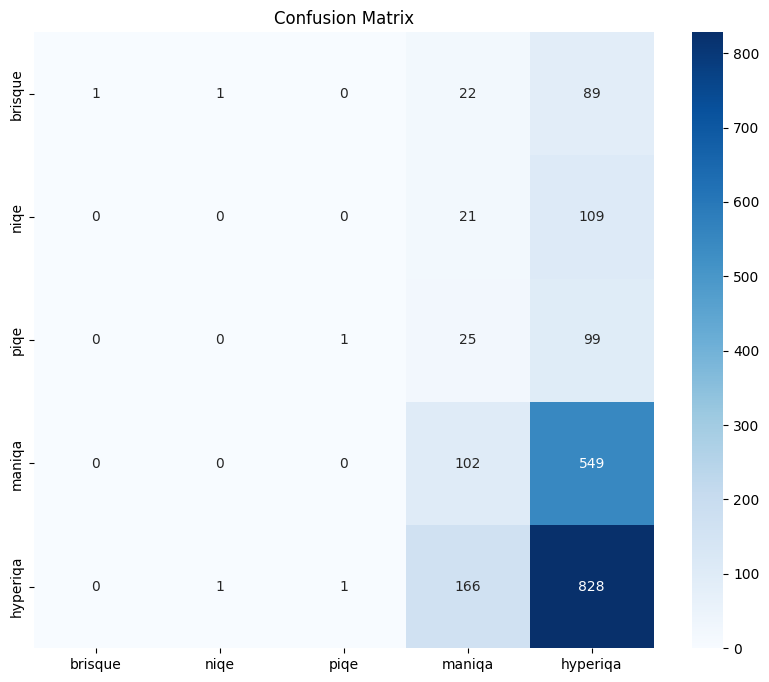

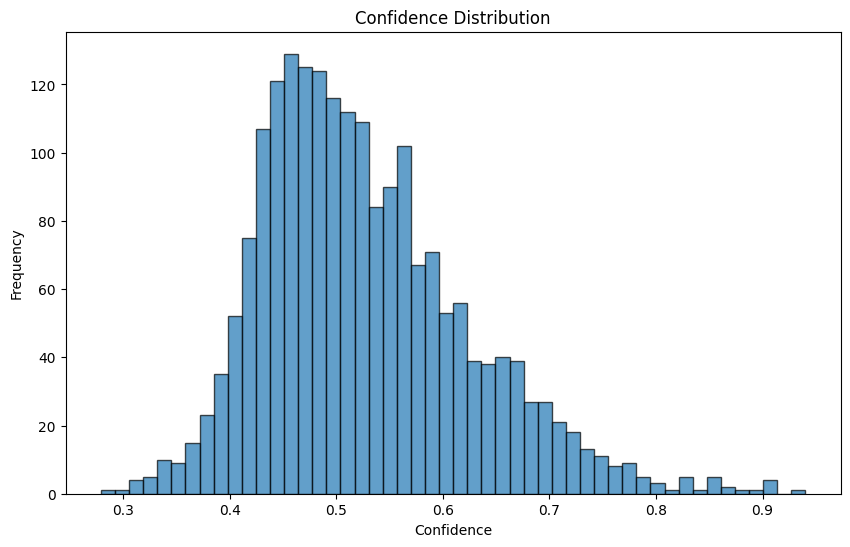

Confidence: mean=0.5265, median=0.5114


In [6]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

df = pd.read_csv("router_training_data.csv")
X = df[feature_names].values
y = df["best_method_label"].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

router = XGBClassifier(n_estimators=200, learning_rate=0.05, max_depth=6, subsample=0.8, 
                       colsample_bytree=0.8, gamma=0.1, reg_lambda=1.0, reg_alpha=0.1,
                       objective="multi:softprob", num_class=5, n_jobs=-1, random_state=42, eval_metric="mlogloss")

router.fit(X_train_scaled, y_train, eval_set=[(X_train_scaled, y_train), (X_test_scaled, y_test)], verbose=50)

y_pred_proba = router.predict_proba(X_test_scaled)
print(f"Train Acc: {accuracy_score(y_train, router.predict(X_train_scaled)):.4f}")
print(f"Test Acc: {accuracy_score(y_test, router.predict(X_test_scaled)):.4f}")
print(classification_report(y_test, router.predict(X_test_scaled), target_names=iqa_methods))

cm = confusion_matrix(y_test, router.predict(X_test_scaled))
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=iqa_methods, yticklabels=iqa_methods)
plt.title('Confusion Matrix')
plt.show()

confidences = np.max(y_pred_proba, axis=1)
plt.figure(figsize=(10, 6))
plt.hist(confidences, bins=50, edgecolor='black', alpha=0.7)
plt.xlabel('Confidence')
plt.ylabel('Frequency')
plt.title('Confidence Distribution')
plt.show()

router.save_model("router_xgb.json")
joblib.dump(scaler, "scaler.pkl")
print(f"Confidence: mean={np.mean(confidences):.4f}, median={np.median(confidences):.4f}")

1. noise_std_estimate: 0.0577
2. canny_edge_ratio: 0.0574
3. tenengrad: 0.0559
4. laplacian_variance: 0.0548
5. median_luminance: 0.0540
6. high_freq_energy: 0.0531
7. kurtosis_luminance: 0.0526
8. rms_contrast: 0.0523
9. mean_luminance: 0.0520
10. percentile_contrast: 0.0520
11. mid_freq_energy: 0.0519
12. lbp_uniformity: 0.0516
13. entropy_luminance: 0.0515
14. std_luminance: 0.0513
15. mean_saturation: 0.0511


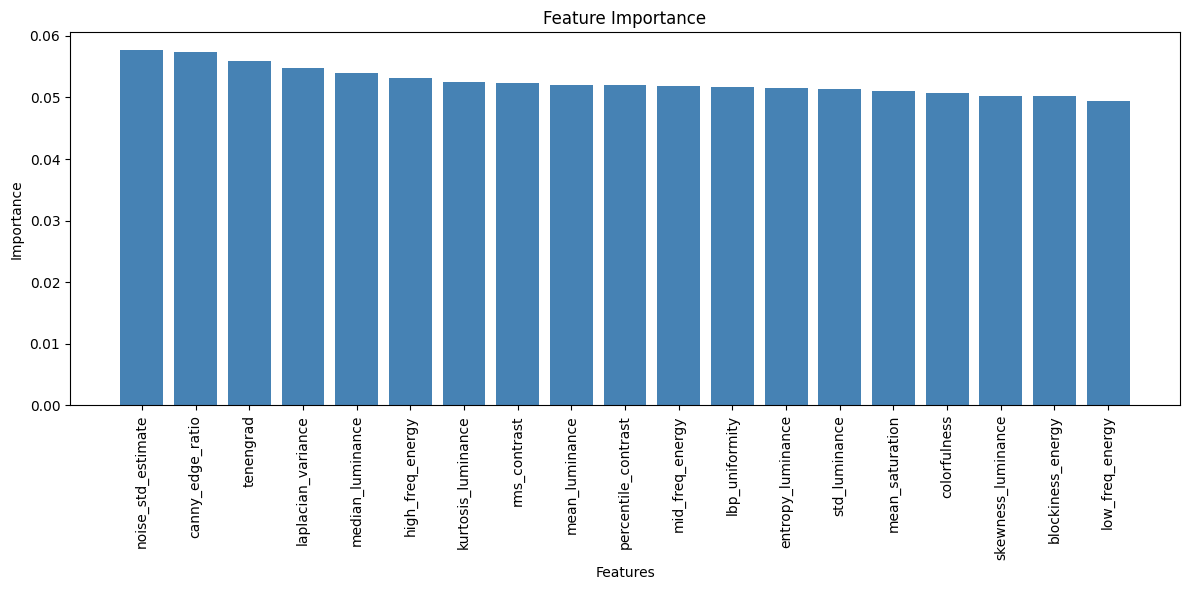

In [7]:
importance = router.feature_importances_
indices = np.argsort(importance)[::-1]

for i in range(min(15, len(importance))):
    print(f"{i+1}. {feature_names[indices[i]]}: {importance[indices[i]]:.4f}")

plt.figure(figsize=(12, 6))
plt.bar(range(len(importance)), importance[indices], color='steelblue')
plt.xticks(range(len(importance)), [feature_names[i] for i in indices], rotation=90)
plt.xlabel("Features")
plt.ylabel("Importance")
plt.title("Feature Importance")
plt.tight_layout()
plt.show()

pd.DataFrame({'Feature': [feature_names[i] for i in indices], 'Importance': importance[indices]}).to_csv("feature_importance.csv", index=False)

In [9]:
from scipy.stats import spearmanr, pearsonr
from sklearn.metrics import mean_squared_error, mean_absolute_error
from router import predict, mos_mapping

df_full = pd.read_csv("router_training_data.csv")
_, test_df = train_test_split(df_full, test_size=0.2, random_state=42, stratify=df_full["best_method_label"])

predictions, confidences, selected_methods, times = [], [], [], []
for idx, row in tqdm(test_df.iterrows(), total=len(test_df)):
    try:
        result = predict(f"koniq10k_512x384/{row['image_name']}", confidence_threshold=0.5)
        predictions.append(result['MOS_estimate'])
        confidences.append(result['confidence'])
        selected_methods.append(result['selected_method'])
        times.append(result['timing']['total_time_ms'])
    except Exception as e:
        print(f"Error: {e}")

ground_truth = test_df['MOS'].values[:len(predictions)]

srocc = spearmanr(predictions, ground_truth)[0]
plcc = pearsonr(predictions, ground_truth)[0]
rmse = np.sqrt(mean_squared_error(ground_truth, predictions))
mae = mean_absolute_error(ground_truth, predictions)

print(f"SROCC: {srocc:.4f} | PLCC: {plcc:.4f} | RMSE: {rmse:.4f} | MAE: {mae:.4f} | Time: {np.mean(times):.2f}ms")

baseline_results = {}
for method in iqa_methods:
    scores = test_df[method].values[:len(predictions)]
    method_mos = mos_mapping[method]['coef'] * scores + mos_mapping[method]['intercept']
    s = spearmanr(method_mos, ground_truth)[0]
    p = pearsonr(method_mos, ground_truth)[0]
    r = np.sqrt(mean_squared_error(ground_truth, method_mos))
    baseline_results[method] = {'SROCC': s, 'PLCC': p, 'RMSE': r}
    print(f"{method}: SROCC={s:.4f}, PLCC={p:.4f}, RMSE={r:.4f}")

plt.figure(figsize=(10, 10))
plt.scatter(ground_truth, predictions, alpha=0.5, s=30, edgecolors='black', linewidths=0.5)
plt.plot([1, 5], [1, 5], 'r--', linewidth=2, label='Perfect')
plt.xlabel('Ground Truth MOS')
plt.ylabel('Predicted MOS')
plt.title(f'SROCC={srocc:.4f}, PLCC={plcc:.4f}, RMSE={rmse:.4f}')
plt.legend()
plt.xlim(1, 5)
plt.ylim(1, 5)
plt.tight_layout()
plt.savefig("prediction_scatter.png", dpi=300)
plt.show()

pd.DataFrame({'image_name': test_df['image_name'].values[:len(predictions)], 'ground_truth': ground_truth, 
              'predicted': predictions, 'method': selected_methods, 'confidence': confidences,
              'time_ms': times, 'error': np.abs(predictions - ground_truth)}).to_csv("evaluation_results.csv", index=False)

pd.DataFrame({'Method': ['Adaptive'] + iqa_methods,
              'SROCC': [srocc] + [baseline_results[m]['SROCC'] for m in iqa_methods],
              'PLCC': [plcc] + [baseline_results[m]['PLCC'] for m in iqa_methods],
              'RMSE': [rmse] + [baseline_results[m]['RMSE'] for m in iqa_methods]}).to_csv("performance_summary.csv", index=False)

d:\Github\NR-IQA\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
  0%|          | 0/2015 [00:00<?, ?it/s]d:\Github\NR-IQA\.venv\Lib\site-packages\skimage\feature\texture.py:385: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(
d:\Github\NR-IQA\.venv\Lib\site-packages\timm\models\layers\__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


Loading pretrained model MANIQA from C:\Users\aryam\.cache\torch\hub\pyiqa\ckpt_koniq10k.pt


  0%|          | 1/2015 [00:15<8:27:07, 15.11s/it]d:\Github\NR-IQA\.venv\Lib\site-packages\skimage\feature\texture.py:385: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


Loading pretrained model HyperNet from C:\Users\aryam\.cache\torch\hub\pyiqa\HyperIQA-resnet50-koniq10k-c96c41b1.pth


  0%|          | 2/2015 [00:16<4:01:25,  7.20s/it]d:\Github\NR-IQA\.venv\Lib\site-packages\skimage\feature\texture.py:385: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(
  0%|          | 3/2015 [00:17<2:26:53,  4.38s/it]d:\Github\NR-IQA\.venv\Lib\site-packages\skimage\feature\texture.py:385: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(
  0%|          | 4/2015 [00:30<4:12:34,  7.54s/it]d:\Github\NR-IQA\.venv\Lib\site-packages\skimage\feature\texture.py:385: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical diff

KeyboardInterrupt: 

In [10]:
from xgboost import XGBClassifier

def assess_image(image_path, confidence_threshold=0.5):
    """
    Assess a custom image and return the adaptive MOS estimate plus details.
    Uses the already-trained router (router_xgb.json) and scaler (scaler.pkl).
    Falls back to loading them from disk if not in memory.
    """
    if not os.path.isfile(image_path):
        raise FileNotFoundError(f"Image not found: {image_path}")

    # Ensure router + scaler in memory
    global router, scaler
    if 'router' not in globals() or router is None:
        router = XGBClassifier()
        router.load_model("router_xgb.json")
    if 'scaler' not in globals() or scaler is None:
        scaler = joblib.load("scaler.pkl")

    # Use existing predict helper (already imported earlier)
    result = predict(image_path, confidence_threshold=confidence_threshold)

    # Nicely print a short summary
    print(f"Image: {os.path.basename(image_path)}")
    print(f"Selected method: {result['selected_method']} (confidence={result['confidence']:.3f})")
    print(f"MOS estimate: {result['MOS_estimate']:.3f}")
    if 'fallback_used' in result:
        print(f"Fallback used: {result['fallback_used']}")
    return result

# Example usage (replace with your path):
# r = assess_image("koniq10k_512x384/10316734944.jpg")
r = assess_image("me at night.jpg")

d:\Github\NR-IQA\.venv\Lib\site-packages\skimage\feature\texture.py:385: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


Image: me at night.jpg
Selected method: hyperiqa (confidence=0.509)
MOS estimate: 2.227
